# Data preparation and cleaning

This notebook describes common problems and how to deal with them. It covers the following topics

- Imputing
- Deduplication
- Fixing mistakes
- Binning

It makes use of the titanic dataset to which additional records have been added that contain the problems that are illustrated in this notebook.

In [359]:
# Imports
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.impute import KNNImputer

## Detecting problems

Let's load a data set (a modified version of the Titanic data set) and explore it to find any problems it may have.

In [ ]:
# First we load the data
dft = pd.read_csv("data/titanic_processed.csv")
dft.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1063.000000,1063.000000,1063.000000,855.000000,1063.000000,1063.000000,1063.000000
mean,447.238946,0.379116,2.301035,31.216480,0.512700,0.382879,32.547749
std,260.770475,0.485395,0.837936,18.641281,1.083856,0.807899,48.902782
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400
50%,444.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.458300
75%,673.500000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,891.000000,1.000000,3.000000,130.000000,8.000000,6.000000,512.329200


### Empty values

The first and most obvious thing to check is whether there are empty values in the data.


In [361]:
for col in dft.columns:
    print(f'Column {col: <12} has {dft[col].isna().sum(): 4d} NaN values')


Column PassengerId  has    0 NaN values
Column Survived     has    0 NaN values
Column Pclass       has    0 NaN values
Column Name         has    0 NaN values
Column Sex          has    0 NaN values
Column Age          has  208 NaN values
Column SibSp        has    0 NaN values
Column Parch        has    0 NaN values
Column Ticket       has    0 NaN values
Column Fare         has    0 NaN values
Column Cabin        has  816 NaN values
Column Embarked     has    3 NaN values


### Duplicates

Records have an unpleasant tendency to be duplicated. Luckily Pandas can help detect this.


In [362]:
print(f'Number of duplicates is {dft.duplicated( keep='first').sum()}')

Number of duplicates is 172


### Nonsensical values

Let's check each column to see if the values make sense.

For numerical columns we do this by checking the range of values while for text columns we list the unique values.

This data set has one column for which this is impossible: we likely have no way of determining whether a value in the "Name" column is plausible or not. The same is true for the "Ticket" column which holds the ticket number and for the "Cabin" column which holds the cabin number. It's probably also not useful to check what's in the "PassengerId" column.

In [363]:
columns_to_skip = ['PassengerId', 'Name', 'Ticket', 'Cabin']
for col in dft.columns:
    if col in columns_to_skip:
        continue
    if is_numeric_dtype(dft[col]):
        print(f'Column "{col}" has range {dft[col].min()} - {dft[col].max()}')
    else:
        print(f'Column {col} has values {dft[col].unique()} ')

Column "Survived" has range 0 - 1
Column "Pclass" has range 1 - 3
Column Sex has values ['male' 'female' 'caprio' 'fmale'] 
Column "Age" has range 0.42 - 130.0
Column "SibSp" has range 0 - 8
Column "Parch" has range 0 - 6
Column "Fare" has range 0.0 - 512.3292
Column Embarked has values ['S' 'C' 'Q' nan] 


The "Sex" column has values that are either obvious typos ("fmale") or outright nonsensical ("caprio"). We need to decide on a way to deal with these values.

### Too much detail

Take a look at the distribution of the "Fare" column:

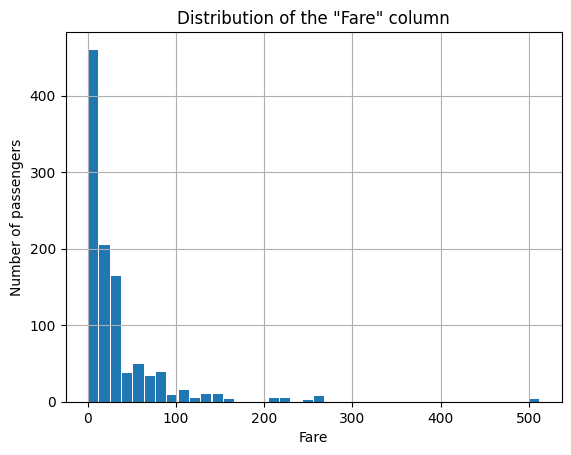

In [364]:
dft['Fare'].hist(bins=40, rwidth=0.9)
plt.title('Distribution of the "Fare" column')
plt.xlabel("Fare")
plt.ylabel("Number of passengers")
plt.show()

Additionally, take a look at the number of passengers per fare:

In [365]:
dft['Fare'].value_counts()

Fare
8.0500     55
13.0000    48
7.8958     47
26.0000    41
7.7500     38
           ..
9.4833      1
8.1125      1
15.7500     1
8.6833      1
13.7917     1
Name: count, Length: 248, dtype: int64

Many records have values in the fare column that are almost, but not quite identical. See, for example, the fares between 7.5 and 8.5.

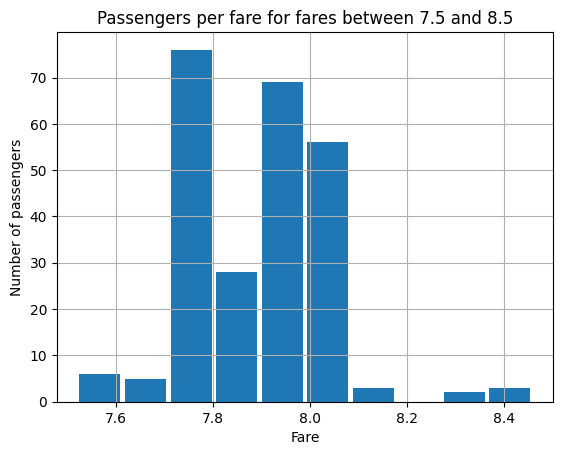

In [366]:
dft[(dft['Fare'] > 7.5) & (dft['Fare'] < 8.5)]['Fare'].hist(bins=10, rwidth=0.9)
plt.title('Passengers per fare for fares between 7.5 and 8.5')
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.show()

Some domain knowledge is necessary to determine whether minute differences like this are actually meaningful. In many cases they are not - but they do bring with them the risk that a model will latch on to these differences and erroneously base its predictions on them. What we want to do is do some form of rounding or "binning" as it's called.

## Fixing problems

### Dealing with empty values

The "Age" column and the "Cabin" column have empty values. We'll ignore the "Cabin" column for now (because what does it actually mean if no cabin was recorded? Was that someone who simply slept on the lower deck? Did they select a cabin once on board? Was their cabin simply not recorded? We will likely never know).

So ... the age column. 

The first and most obvious thing to check is how many records have an empty value in that column:

In [385]:
print(f'Age column has {dft['Age'].isna().sum()} empty values out of a total of {len(dft)}  ({(dft['Age'].isna().sum() / len(dft)) * 100 :.1f}%)')

Age column has 208 empty values out of a total of 1063  (19.6%)


That's a lot. And we need to do something about it because simply throwing away this many data points is unacceptable.

What we need to do is come up with plausible values for these missing values. Coming up with plausible values is called "imputing".

There are several techniques for doing this, each with their own advantages and disadvantages. We will take a look at a few of them.

#### Imputing: using the mean, median or mode.

The simplest and most obvious way to do imputing is to replace the missing values with the mean, median or mode. Which to use depends on the shape of the distribution of the variable.

Let's examine this distribution.

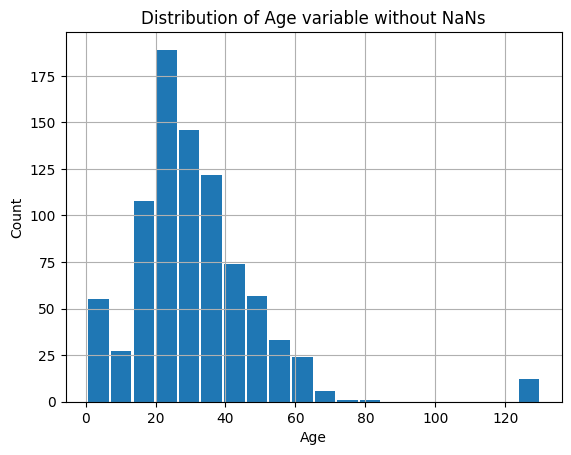

In [386]:
dft[dft['Age'] != np.nan]['Age'].hist(bins=20, rwidth=0.9)
plt.title('Distribution of Age variable without NaNs')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

There's some implausible values above the age of 100 years old. These will skew the arithmetic mean, so we should probably not use the mean to replace missing values. The median or the mode probably makes sense, however.

Let's see what happens when we set the missing values to the median.

Note that in this case the mode is equal to the median, so we can ignore it and focus on the median.

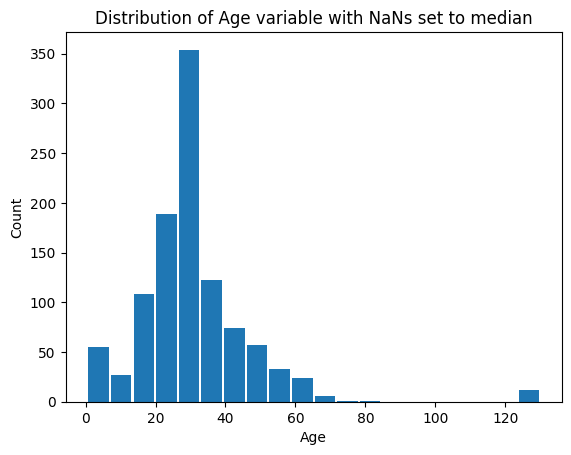

In [387]:

plt.hist(dft['Age'].fillna(dft['Age'].median()), bins=20, rwidth=0.9)
plt.title('Distribution of Age variable with NaNs set to median')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


Ok. For the most part setting the missing values to the median has left the shape of the distribution intact, but the median is now overrepresented - there are now almost twice as many records with the median value. This will likely cause problems later.


#### Imputing: using random values

One way to solve the problem of overrepresentation of the median is simply to set the missing values to a random value taken from the available range of values. Let's see what happens.

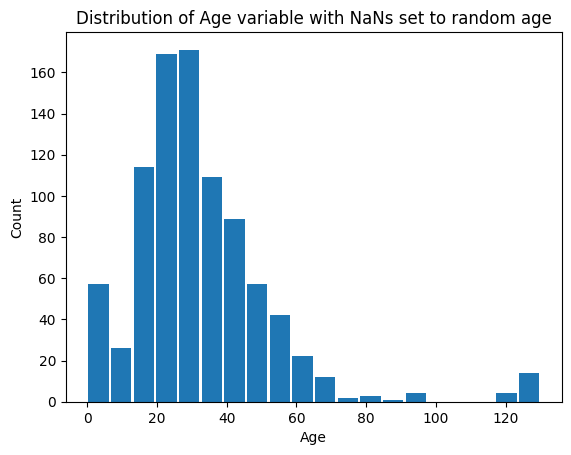

In [388]:
# To fill missing values with random numbers, we need to generate a series (ie column) with these random values.
random_ages = pd.Series(np.random.randint(int(dft['Age'].min()), int(dft['Age'].max()), dft['Age'].isna().sum()))

plt.hist(dft['Age'].fillna(random_ages), bins=20, rwidth=0.9)
plt.title('Distribution of Age variable with NaNs set to random age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Try running the above code block a few times. You will see the distribution change, but overall it looks close enough to the original without the NaNs.


#### Imputing: using random values drawn from a normal distribution

We can improve things further by creating a set of normally distributed random numbers taken from a distributon with a mean and standard deviation similar to the original distribution.

As the mean of the original isn't usable, we'll use the median instead.

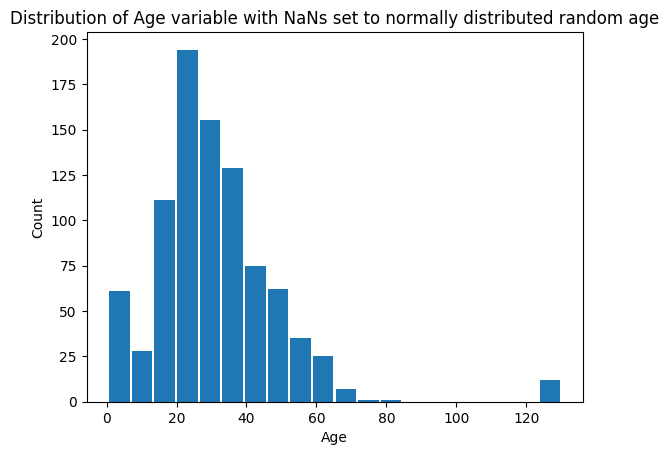

In [389]:
# Luckily for us median and std ignore nan values
age_median = dft['Age'].median()
age_std = dft['Age'].std()
# Notice the following:
#     - Nested list comprehension applying a round() function to each value
#     - if else in list comprehension. We need to make sure ages are not negative.
random_ages = pd.Series([x if x > 0 else x * -1 for x in [round(x) for x in np.random.normal(age_median, age_std, dft['Age'].isna().sum())]])
plt.hist(dft['Age'].fillna(random_ages), bins=20, rwidth=0.9)
plt.title('Distribution of Age variable with NaNs set to normally distributed random age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


This looks much better.


#### Imputing: a problem to consider

In the above example we have filled the "Age" column with values without altering the shape of its distribution. If there is no relationship between this column and the other columns, that is fine. However, if there is, we have now made this relationship weaker because we have assigned values to the "Age" column randomly.

Further on we will learn about a way to deal with this: we can use the other variables to determine the most likely value for the missing value using a K-nearest neighbor imputer. For now we will leave the "Age" column as it is so we can focus on fixing other types of problems.

### Dealing with duplicates

Above, we detected there were duplace records. We want to get rid of them. Luckily Pandas provides us with the means to do so (easily).

How this works:
- `df.duplicated(keep = 'first')` returns a list of True / False values. "True" if the record is considered to be a duplicate, "False" if it's not.
- We then use this list to filter the original dataframe. Normally, applying a list of True / False values as a filter (`df[list_of_true_false]`) will return only those records for which the list has a value of "True". In this case, "True" means the record is a duplicate. What we actually want is to retain only those records for which the list has a value of False. We accomplish this by using the `~` operator (logical NOT) before the filter.

In [390]:
dft_dedup = dft[~dft.duplicated( keep='first')]
# Verify there are no more duplicates:
print(f'After de-duplicating we are left with {dft_dedup.duplicated(keep = 'first').sum()} duplicates')



After de-duplicating we are left with 0 duplicates


### Dealing with nonsensical values

We have found two columns with nonsensical values:
- Not all values in the "Sex" column are correct. Some of these incorrect values are obvious typos, others are plain hot garbage.
- The "Age" column has values ranging from 0.4 to 130. Even today people rarely age to more than 100 years, let alone in 1912.

#### Dealing with nonsensical values in the "Sex" column

The obvious typos in the "Sex" column are easy enough to fix.

Again we use a filter (list of True / False) for this. The filter gives "True" for all records where the "Sex" column matches the condition, false where it doesn't. We can use this to update only those values that match the condition.

In [391]:
dft.loc[dft['Sex'] == 'fmale', 'Sex'] = 'female'
# Verify that the typos are gone.
dft['Sex'].unique()

array(['male', 'female', 'caprio'], dtype=object)

Some incorrect values are a bit more difficult to deal with. We really have no way of knowing what "caprio" means.

To come up with a solution, we need to know how many records contain this value.

In [392]:
print(f'The number of records with a nonsensical value in the "Sex" column is {len(dft[dft['Sex'] == 'caprio'])} (out of a total of {len(dft)} records so {(len(dft[dft['Sex'] == 'caprio']) / len(dft)) * 100 :.1f}% of the total')

The number of records with a nonsensical value in the "Sex" column is 26 (out of a total of 1063 records so 2.4% of the total


Now that we know what we're dealing with, we have to make a decision. Throw them out or replace them with values that make sense? And if the latter: what does "values that make sense" mean? For numerical values we can use the mean, median or mode but for a categorical value we have to do more work.

One option is simply to assign the value that is the most common. For this we need to know the counts for each value. The `value_counts` command tells us this (`group_by` with `count` would also work).

In [393]:
dft['Sex'].value_counts()


Sex
male      655
female    382
caprio     26
Name: count, dtype: int64

In this case simply assigning the majority correct value is not the best option as the difference between the most common correct value and the least common correct value is not very large.

An especially fancy way to handle this problem is to use something known as "K-Nearest Neighbor Imputation". For this technique, "similarity" is calculated between rows (by treating each row as a coördinate in a multi-dimensional space). We can then replace the incorrect values with the correct values in the nearest neighbors (hence the name of the algorithm - $K$ is simply the *number* of neighbors to consider).

Of course we will have a problem if it turns out that the incorrect records only have neighbors that are incorrect themselves.

In [400]:

# We need to create a new data frame containing only the numeric frames because KNNImputer only works with numeric values.
# Reuse the columns_to_skip array we made above. Notice the nested list comprehension.
dft_imp = dft[[c for c in dft.columns if c not in columns_to_skip]].copy()

# We need to give the "Sex" column numerical values so we can use it with KNNImputer.
# Notice we use a dict to translate string values to numbers. This allows us to reuse it later.
translation = {
    'female' : 1,
    'male' : 2,
    # The sex we want to impute needs to be set to NaN so KNNImputer can fill it.
    'caprio' : np.nan,
}
for (orig, new) in translation.items():
    dft_imp.loc[dft_imp['Sex'] == orig, 'Sex'] = new



# The "Embarked" column also has non-numeric values. Since the exact value doesn't
# matter, just give it any value
emb_val = 1
for val in dft_imp['Embarked'].unique():
    dft_imp.loc[dft_imp['Embarked'] == val, 'Embarked'] = emb_val
    emb_val +=1


# Now run the imputer. Let's go with a low value for the number of neighbors to consider.
imputer = KNNImputer(n_neighbors=2)
imputed = imputer.fit_transform(dft_imp)
print(f"After imputation we have: {imputed}")

# Woops - we no longer have a data frame. We need to restore it.
imputed = pd.DataFrame(imputed, columns = dft_imp.columns)

# Let's see if it worked.
print(f"After imputation we end up with the following unique values in the 'Sex' column: {imputed['Sex'].unique()}")

# Ok. That didn't work. In some cases the imputer couldn't decide on a value so it took the average.
# Let's see how often that happened:
print(f"Number of records with a value of 1.5: {len(imputed[imputed['Sex'] == 1.5])}")
print(imputed['Sex'].value_counts())

# Let's see if increasing the number of neighbors helps:
imputer = KNNImputer(n_neighbors=10)
imputed = imputer.fit_transform(dft_imp)
imputed = pd.DataFrame(imputed, columns = dft_imp.columns)
print(f"After increasing the number of neighbors we end up with the following: \n{imputed['Sex'].value_counts()}")

# You can try other values for n_neighbors but you will find things never really improve.
# Let's decide to solve the problem by rounding to the nearest integer.
imputed['Sex'] = imputed['Sex'].round(0)

# Finally translate the imputed sex column back to strings using the translation map above.
# We need to change the data type to a string representation of an int to avoid complaints.
imputed['Sex'] = imputed['Sex'].astype(int).astype(str)
for stringval, number in translation.items():
    number_as_string = str(number)
    imputed.loc[imputed['Sex'] == number_as_string, 'Sex'] = stringval

# And, of course, update the original Sex column to the new Sex column.
# To make things easier to work with, create a new dataframe.
# Notice use of reset_index. This is necessary to make sure the original columns
# and the imputed column line up correctly.
dft_s_fixed = dft[[col for col in dft.columns if col != 'Sex']].reset_index()
dft_s_fixed['Sex'] = imputed.reset_index()['Sex']
print(f'After imputing we have {dft_s_fixed['Sex'].value_counts()}')


After imputation we have: [[  0.       1.       2.     ...   1.      79.65     1.    ]
 [  1.       3.       1.     ...   1.      12.475    1.    ]
 [  0.       3.       2.     ...   0.       8.05     1.    ]
 ...
 [  1.       1.       1.     ...   0.     135.6333   2.    ]
 [  1.       1.       2.     ...   1.     512.3292   2.    ]
 [  0.       3.       1.     ...   4.      21.075    1.    ]]
After imputation we end up with the following unique values in the 'Sex' column: [2.  1.  1.5]
Number of records with a value of 1.5: 6
Sex
2.0    668
1.0    389
1.5      6
Name: count, dtype: int64
After increasing the number of neighbors we end up with the following: 
Sex
2.0    657
1.0    382
1.5      6
1.4      4
1.9      3
1.2      3
1.8      3
1.7      3
1.6      2
Name: count, dtype: int64
After imputing we have Sex
male      674
female    389
Name: count, dtype: int64


#### Dealing with nonsensical values in the "Age" column

Dealing with nonsensical values in the "Age" column is exactly like dealing with missing values. We know human beings don't live until the age of 130, especially not in 1912, so we decide on a cutoff point, set all the values above that cutoff point to NaN and then proceed as with the missing values above.

### Dealing with too much detail: binning

The graph "Passengers per fare for fares between 7.5 and 8.5" above showed the "Fare" variable has too much detail. In some cases, such detail can lead a model astray and cause it to make predictions based on minute differences that in reality are not meaningful.

Some domain knowledge is required to determine whether a difference is "minute" or "meaningful". For the purposes of this notebook, let's assume the smaller differences in the "Fares" column are not actually meaningful.

We are going to group the fares in a limited number of so-called "bins" (recall the "bins" parameter for the histogram plot - it is essentially the same thing).

First we need to remember what the distribution of the variable looks like again:

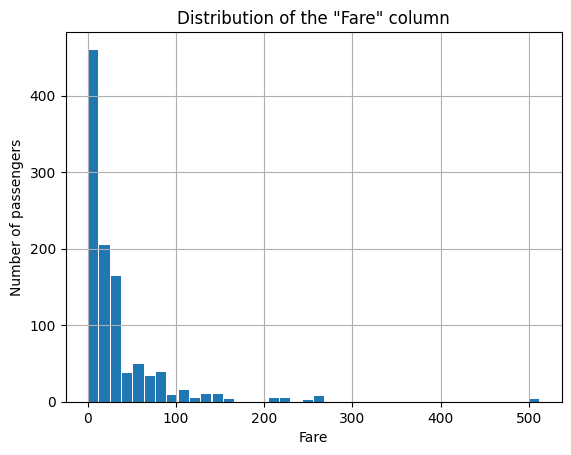

In [395]:
dft['Fare'].hist(bins=40, rwidth=0.9)
plt.title('Distribution of the "Fare" column')
plt.xlabel("Fare")
plt.ylabel("Number of passengers")
plt.show()

It looks like it would be useful to do some grouping. Let's put all fares > 200 in a bin and all fares between 100 and 200 too. For the fares below 100 we need to take a closer look to see if they can be grouped together or not.

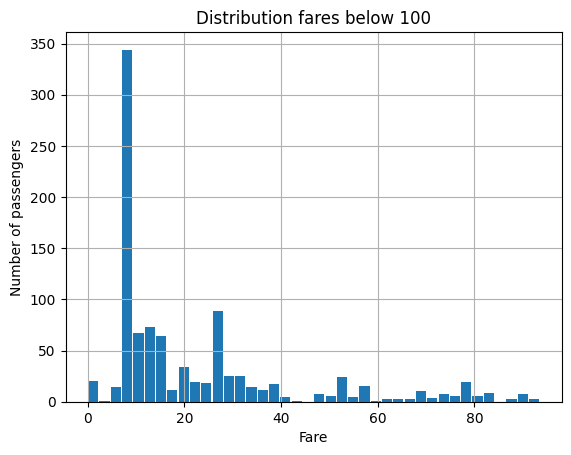

In [396]:
dft[dft['Fare'] < 100]['Fare'].hist(bins=40, rwidth=0.9)
plt.title('Distribution fares below 100')
plt.xlabel("Fare")
plt.ylabel("Number of passengers")
plt.show()

Dividing values into bins is a matter of domain knowledge and of experimentation.

In this example we will use the following bins (but feel free to try different ones):
- Less than 10
- Between 10 and 45
- Between 45 and 100
- Between 100 and 200
- More than 200

In [397]:
# For this example we will use the "map" function that applies a function
# to each element in a series. The function can be anynomous (lambda)
# such as in this simple example:
dft['Fare'].map(lambda f : 10 if f < 10 else 100, na_action = 'ignore' )


0       100
1       100
2        10
3        10
4        10
       ... 
1058     10
1059     10
1060    100
1061    100
1062    100
Name: Fare, Length: 1063, dtype: int64

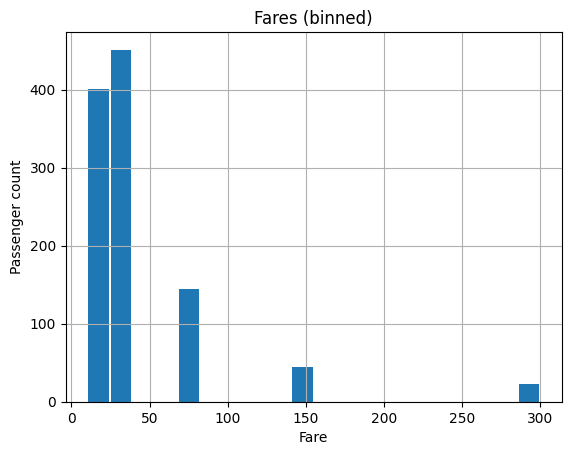

In [398]:

# For the fare column, however, we need 5 categories so using an inline function
# like this would result in unreadable code. Instead, let's create a function
def return_binned_fare(fare):
    if fare <= 10:
        return 10
    if fare <= 45:
        return 30
    if fare <= 100:
        return 75
    if fare <= 200:
        return 150
    return 300

# We can apply this function in a lambda to create our bins:
dft['Fare'].map(lambda f : return_binned_fare(f), na_action='ignore').hist(bins=20, rwidth=0.9)
plt.title("Fares (binned)")
plt.xlabel("Fare")
plt.ylabel("Passenger count")
plt.show()

The values we assigned to each bin are, of course, arbitrary. In fact, one could argue that assigning any value at all to bins like these is arbitrary because binned fares are not, in fact, numeric values at all, but rather categorical values.

Let's combine a dictionary and a function to create fare categories. Note we use a list of dictionaries so we can easily add categories later.

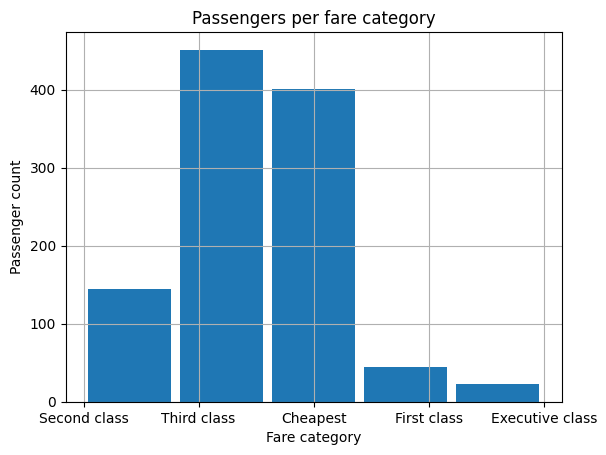

In [399]:
categories = [
    { 'min' : 0,
     'max' : 10,
     'category' : 'Cheapest'},
    { 'min' : 10,
     'max' : 45,
     'category' : 'Third class'},
    { 'min' : 45,
     'max' : 100,
     'category' : 'Second class'},
    { 'min' : 100,
     'max' : 200,
     'category' : 'First class'},
    { 'min' : 200,
     'max' : 999, # Some unlikely large number
     'category' : 'Executive class'},
]

def return_fare_category(fare):
    for category in categories:
        if fare >= category['min'] and fare < category['max']:
            return category['category']
    # Should not happen, but just in case:
    return None

dft['Fare'].map(lambda f : return_fare_category(f)).hist(bins = len(categories),rwidth=0.9)
plt.title('Passengers per fare category')
plt.xlabel('Fare category')
plt.ylabel('Passenger count')
plt.show()


And there you have it: fares neatly assigned to meaningful categories. Of course in a real data science project you would use your domain knowledge (business understanding) to determine what the categories should be, but for this notebook the current example suffices.

## Conclusion

This brings us to the end of this notebook on data preparation and cleaning. We have only seen a tiny fraction of what is possible (or even necessary). However, in summary all problems with data boil down to one of three things:

- It's wrong.
- It's missing.
- It's in a form that is inconvenient.

To close off, let's see an example of how changing the *form* of data (ie creating new columns with values that are based on other columns) can lead to insights that are impossible to obtain without manipulating the source data first.

### Extra: explaining the missing values in the "Cabin" column

Look back at the section "Empty values" under "Detecting problems". We fixed the empty values in the "Age" column but not those in the "Cabin" column. A lot of the values, in fact the vast majority of them, were missing.

We will now try to transform our data to see if we can find out why that is.

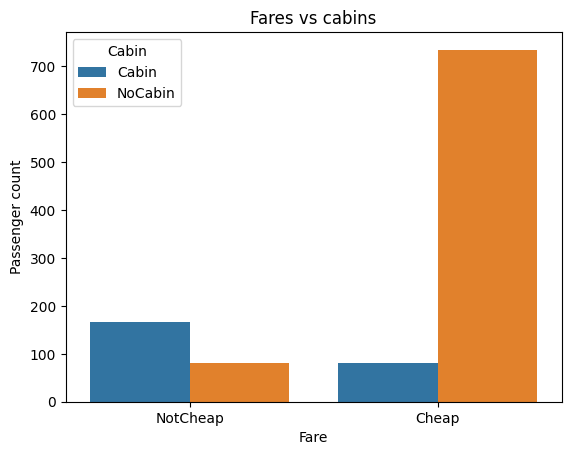

In [382]:

# Work on copies to avoid breaking our original data.

cabin_copy = pd.DataFrame(dft['Cabin'].copy())
cabin_copy.loc[cabin_copy['Cabin'].isnull(), 'Cabin'] = 'NoCabin'
cabin_copy.loc[cabin_copy['Cabin'] != 'NoCabin', 'Cabin'] = 'Cabin'

fare_copy = pd.DataFrame(dft['Fare'].round().astype('int')).copy()

# Use a variable to test different values for the threshold between cheap and non-cheap fares.
max_cheap = 35

# We need indexes to update the values in our columns.
indexes_cheap = fare_copy['Fare'] < max_cheap
indexes_not_cheap = fare_copy['Fare'] >= max_cheap
fare_copy['Fare'] = fare_copy['Fare'].astype('str') # Prevents warnings.
fare_copy.loc[indexes_cheap] = 'Cheap'
fare_copy.loc[indexes_not_cheap] = 'NotCheap'


df_compare = pd.concat([cabin_copy, fare_copy], axis=1)


sns.countplot(df_compare, x='Fare',hue='Cabin')
plt.title('Fares vs cabins')
plt.ylabel('Passenger count')
plt.show()




And there we have it - there seems to be a correlation between having a cabin and paying a higher fare.

Althouh, to be fair, this picture may also be the result of there simply being more passengers paying a cheap fare than there are paying a "NotCheap" fare. For a more correct picture, we need to use a sample of the data where both classes ("Cheap" and "NotCheap") are represented equally.

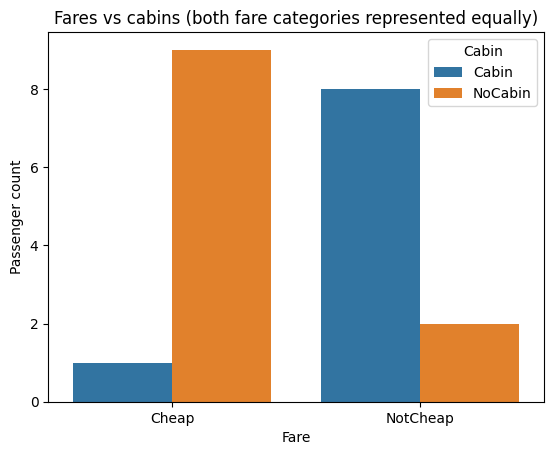

In [401]:
# Use the groupby.sample method to draw 10 samples from each of the two groups
# ("Cheap" and "NotCheap"). Then compare them as we did before.
# The random_state parameter makes sure we can reproduce the result.
# Trial and error has shown that 10 is the maximum number of samples to keep things even.
sns.countplot(df_compare.groupby('Fare').sample(n=10, random_state=1), x='Fare',hue='Cabin')
plt.title('Fares vs cabins (both fare categories represented equally)')
plt.ylabel('Passenger count')
plt.show()

